# Imports Libraries

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Loading Datasets

In [98]:
# LOading datasets train and test
def date_parser(date_str):
    return pd.to_datetime(date_str, format='%Y-%m-%d')

train_df = pd.read_csv("../demand-forecasting-kernels-only/train.csv",parse_dates=['date'], date_parser=date_parser)
test_df = pd.read_csv("../demand-forecasting-kernels-only/test.csv", index_col= 0,parse_dates=['date'], date_parser=date_parser)

C:\Users\Yi Heng\AppData\Local\Temp\ipykernel_19680\623095689.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  train_df = pd.read_csv("../demand-forecasting-kernels-only/train.csv",parse_dates=['date'], date_parser=date_parser)
C:\Users\Yi Heng\AppData\Local\Temp\ipykernel_19680\623095689.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  test_df = pd.read_csv("../demand-forecasting-kernels-only/test.csv", index_col= 0,parse_dates=['date'], date_parser=date_parser)


In [99]:
print(train_df.shape)
# train_df = train_df.sort_values('store')
train_df.head()

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [100]:
print(test_df.shape)
test_df.head()

(45000, 3)


,date,store,item
id,,,
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1


In [101]:
print("===========Training dataset dtypes=================")
print(train_df.dtypes)
print("\n===========Testing dataset dtypes==================")
print(test_df.dtypes)

===========Training dataset dtypes=================
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

===========Testing dataset dtypes==================
date     datetime64[ns]
store             int64
item              int64
dtype: object


In [102]:
# changing dtypes of date and sales

train_df = train_df.astype({"sales": "float64", "store": "category", "item": "category"})
test_df = test_df.astype({"store": "category", "item": "category"})

In [103]:
print("===========Training dataset dtypes=================")
print(train_df.dtypes)
print("\n===========Testing dataset dtypes==================")
print(test_df.dtypes)

===========Training dataset dtypes=================
date     datetime64[ns]
store          category
item           category
sales           float64
dtype: object

===========Testing dataset dtypes==================
date     datetime64[ns]
store          category
item           category
dtype: object


# Feature Enginering

In [104]:
def createAdditionalFeatures(df):

        df = df.copy()
        df["day"] = df.index.dayofweek
        df["quarter"] = df.index.quarter
        df['year'] = df.index.year
        df['month'] = df.index.month
        df['dayofyear'] = df.index.dayofyear
        df['dayofmonth'] = df.index.day
        df['weekofyear'] = df.index.isocalendar().week
        df['weekday'] = df.index.weekday
        # df['is_month_start'] = df.index.is_month_start
        # df['is_month_end'] = df.index.is_month_end
        # df['is_quarter_start'] = df.index.is_quarter_start
        # df['is_quarter_end'] = df.index.is_quarter_end
        # df['is_year_start'] = df.index.is_year_start
        # df['is_year_end'] = df.index.is_year_end
        df['daily_avg'] = df.groupby(["item", "store", "day"])["sales"].transform('median')
        df['monthly_avg'] = df.groupby(["item", "store", "month"])["sales"].transform('median')
        # df['mean_store_item_month'] = df.groupby(["month", "item", "store"])["sales"].transform('mean')
        df['item_month_sum'] = df.groupby(["month","item"])["sales"].transform('median')
        df['store_month_sum'] = df.groupby(["store", "month"])["sales"].transform('median')
        # df['testing'] = df.groupby(["store", "item"])["sales"].transform(lambda x: x.rolling(4000).median())

        for lag in [91, 126, 364, 728, 1092]:
                df[f"lag_{lag}"] = df.groupby(["store", "item"])["sales"].transform(lambda x: x.shift(lag))
                
        return df

In [105]:
def convertToCategory(df):
    cols = ["day","quarter", "year", "month", "dayofyear", "dayofmonth", "weekofyear", "weekday",
            # "is_month_start", "is_month_end", "is_quarter_start", "is_quarter_end", "is_year_start", "is_year_end", 'mean_store_item_month', 
            "daily_avg", "monthly_avg", "item_month_sum", "store_month_sum"]

    for col in cols:
        df = df.astype({col: "category"})
    
    return df

In [106]:
training_df = train_df.set_index("date")
training_df = createAdditionalFeatures(training_df)
training_df = convertToCategory(training_df)
print(training_df.shape)
training_df.tail()

(913000, 20)


,store,item,sales,day,quarter,year,month,dayofyear,dayofmonth,weekofyear,weekday,daily_avg,monthly_avg,item_month_sum,store_month_sum,lag_91,lag_126,lag_364,lag_728,lag_1092
date,,,,,,,,,,,,,,,,,,,,
2017-12-27,10,50,63.0,2,4,2017,12,361,27,52,2,71.0,56.0,48.0,42.0,80.0,104.0,43.0,51.0,40.0
2017-12-28,10,50,59.0,3,4,2017,12,362,28,52,3,73.0,56.0,48.0,42.0,82.0,89.0,68.0,44.0,46.0
2017-12-29,10,50,74.0,4,4,2017,12,363,29,52,4,79.0,56.0,48.0,42.0,90.0,98.0,63.0,59.0,53.0
2017-12-30,10,50,62.0,5,4,2017,12,364,30,52,5,83.0,56.0,48.0,42.0,103.0,92.0,64.0,63.0,61.0
2017-12-31,10,50,82.0,6,4,2017,12,365,31,52,6,87.0,56.0,48.0,42.0,99.0,116.0,69.0,81.0,57.0


# XGBoost Cross Validation

In [107]:
tss = TimeSeriesSplit(n_splits= 5, test_size= 24*365*10, gap= 24)
training_df = training_df.sort_index()

preds = []
scores = []

features = [col for col in training_df.columns if col not in ["sales"]]
target = "sales"

params = {
        'base_score': 0.5, 
        'booster': "gbtree",
        'n_estimators': 2000, 
        'early_stopping_rounds': 50,
        'learning_rate': 0.1,
        'enable_categorical': True,
        'tree_method': 'hist',
        'objective': 'reg:squarederror',
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'alpha': 0.2,
        'lambda': 0.2,}

for index, (train_id, val_id) in enumerate(tss.split(training_df)):

    train = training_df.iloc[train_id]
    val = training_df.iloc[val_id]

    X_train = train[features]
    y_train = train[target]

    X_test = val[features]
    y_test = val[target]

    print(f"============================Fold {index}================================")
    reg = xgb.XGBRegressor(**params)

    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose= 200)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    print("\n")

============================Fold 0================================
[0]	validation_0-rmse:49.27427	validation_1-rmse:49.92782
[153]	validation_0-rmse:6.75136	validation_1-rmse:7.39544


============================Fold 1================================
[0]	validation_0-rmse:49.38997	validation_1-rmse:60.72105
[151]	validation_0-rmse:6.79950	validation_1-rmse:9.52853


============================Fold 2================================
[0]	validation_0-rmse:50.99061	validation_1-rmse:56.63997
[200]	validation_0-rmse:6.88169	validation_1-rmse:8.02424
[275]	validation_0-rmse:6.78542	validation_1-rmse:8.02148


============================Fold 3================================
[0]	validation_0-rmse:51.66878	validation_1-rmse:60.03991
[139]	validation_0-rmse:7.05106	validation_1-rmse:8.39076


============================Fold 4================================
[0]	validation_0-rmse:52.58257	validation_1-rmse:61.45895
[200]	validation_0-rmse:7.05518	validation_1-rmse:8.24353
[357]	validation_0-

In [108]:
print(f"Fold Scores: {scores}")
print(f"Average Score: {np.mean(scores):0.2f}")

Fold Scores: [7.377713899002961, 9.482276272648349, 8.02898911368988, 8.343199184923488, 8.22372927416484]
Average Score: 8.29


# Retraining XGBoost Model and Predict the Future

In [109]:
# Retrain using all data for predicting future 
training_df = training_df.sort_values(["store","item"], ascending=[True, True])
X_all = training_df[features]
y_all =training_df[target]

params = {
        'base_score': 0.5, 
        'booster': "gbtree",
        'n_estimators': 2000, 
        'early_stopping_rounds': 50,
        'learning_rate': 0.1,
        'enable_categorical': True,
        'tree_method': 'hist',
        'objective': 'reg:squarederror',
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'alpha': 0.2,
        'lambda': 0.2,}

reg = xgb.XGBRegressor(**params,)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all),],
        verbose= 200)

[0]	validation_0-rmse:53.47845
[200]	validation_0-rmse:7.14898
[400]	validation_0-rmse:6.94742
[600]	validation_0-rmse:6.80263
[800]	validation_0-rmse:6.68148
[1000]	validation_0-rmse:6.57621
[1200]	validation_0-rmse:6.48258
[1400]	validation_0-rmse:6.39930
[1600]	validation_0-rmse:6.32122
[1800]	validation_0-rmse:6.24707
[1999]	validation_0-rmse:6.17957


XGBRegressor(alpha=0.2, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=50,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.2, learning_rate=0.1,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None, ...)

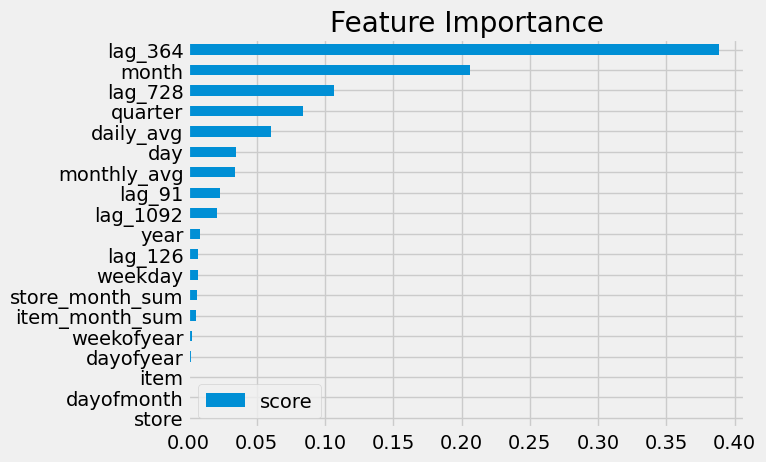

In [110]:
feature_importance = pd.DataFrame(data=reg.feature_importances_,
                                  index=reg.feature_names_in_,
                                  columns= ["score"])

feature_importance.sort_values('score').plot(kind= "barh", title= "Feature Importance")
plt.show()

In [111]:
test_df = test_df.set_index("date")
df = pd.concat([training_df, test_df])
df = createAdditionalFeatures(df)
df = convertToCategory(df)
print(df.shape)
df.tail()

(958000, 20)


,store,item,sales,day,quarter,year,month,dayofyear,dayofmonth,weekofyear,weekday,daily_avg,monthly_avg,item_month_sum,store_month_sum,lag_91,lag_126,lag_364,lag_728,lag_1092
date,,,,,,,,,,,,,,,,,,,,
2018-03-27,10,50,NaN,1,1,2018,3,86,27,13,1,68.0,67.0,59.0,51.0,41.0,81.0,60.0,73.0,61.0
2018-03-28,10,50,NaN,2,1,2018,3,87,28,13,2,71.0,67.0,59.0,51.0,63.0,81.0,73.0,68.0,61.0
2018-03-29,10,50,NaN,3,1,2018,3,88,29,13,3,73.0,67.0,59.0,51.0,59.0,87.0,68.0,75.0,77.0
2018-03-30,10,50,NaN,4,1,2018,3,89,30,13,4,79.0,67.0,59.0,51.0,74.0,81.0,69.0,83.0,79.0
2018-03-31,10,50,NaN,5,1,2018,3,90,31,13,5,83.0,67.0,59.0,51.0,62.0,78.0,101.0,82.0,81.0


In [112]:
future_df = df.loc[df.sales.isna()].copy()
future_df["pred"] = reg.predict(future_df[features])
print(future_df.shape)
future_df.head()

(45000, 21)


,store,item,sales,day,quarter,year,month,dayofyear,dayofmonth,weekofyear,...,daily_avg,monthly_avg,item_month_sum,store_month_sum,lag_91,lag_126,lag_364,lag_728,lag_1092,pred
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1,1,NaN,0,1,2018,1,1,1,1,...,16.0,13.0,14.0,31.0,12.0,15.0,15.0,12.0,14.0,13.206521
2018-01-02,1,1,NaN,1,1,2018,1,2,2,1,...,18.0,13.0,14.0,31.0,18.0,21.0,10.0,12.0,9.0,13.351491
2018-01-03,1,1,NaN,2,1,2018,1,3,3,1,...,19.0,13.0,14.0,31.0,15.0,22.0,16.0,16.0,13.0,15.880483
2018-01-04,1,1,NaN,3,1,2018,1,4,4,1,...,19.0,13.0,14.0,31.0,20.0,26.0,14.0,12.0,18.0,16.709322
2018-01-05,1,1,NaN,4,1,2018,1,5,5,1,...,21.0,13.0,14.0,31.0,19.0,38.0,24.0,12.0,18.0,17.440975


In [113]:
future_df.tail()

,store,item,sales,day,quarter,year,month,dayofyear,dayofmonth,weekofyear,...,daily_avg,monthly_avg,item_month_sum,store_month_sum,lag_91,lag_126,lag_364,lag_728,lag_1092,pred
date,,,,,,,,,,,,,,,,,,,,,
2018-03-27,10,50,NaN,1,1,2018,3,86,27,13,...,68.0,67.0,59.0,51.0,41.0,81.0,60.0,73.0,61.0,69.827972
2018-03-28,10,50,NaN,2,1,2018,3,87,28,13,...,71.0,67.0,59.0,51.0,63.0,81.0,73.0,68.0,61.0,74.702354
2018-03-29,10,50,NaN,3,1,2018,3,88,29,13,...,73.0,67.0,59.0,51.0,59.0,87.0,68.0,75.0,77.0,74.361374
2018-03-30,10,50,NaN,4,1,2018,3,89,30,13,...,79.0,67.0,59.0,51.0,74.0,81.0,69.0,83.0,79.0,81.801193
2018-03-31,10,50,NaN,5,1,2018,3,90,31,13,...,83.0,67.0,59.0,51.0,62.0,78.0,101.0,82.0,81.0,80.166687


# Forecasting Total Sales

In [114]:
pred_total_sales_df = future_df.reset_index()[["date","pred"]].set_index("date").rename(columns= {"pred":"sales"})

year_month = pred_total_sales_df.index.to_period("M")

pred_total_sales_df = pred_total_sales_df.groupby(year_month).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})
print(pred_total_sales_df.shape)
pred_total_sales_df.head()

(3, 7)


sales                                                           
         count          sum       mean     median        std       min   
date                                                                     
2018-01  15500  617578.3750  39.843765  37.240147  19.041022  7.157292  \
2018-02  14000  626537.9375  44.752708  42.162956  21.495727  7.594585   
2018-03  15500  830982.9375  53.611801  50.602005  25.689020  9.273731   

                     
                max  
date                 
2018-01  106.775421  
2018-02  122.494537  
2018-03  141.082535

In [115]:
total_sales_df = train_df.drop(columns = ["store", "item"]).set_index("date")

year_month = total_sales_df.index.to_period("M")
total_sales_df = total_sales_df.groupby(year_month).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})
total_sales_df = pd.concat([total_sales_df,pred_total_sales_df])
total_sales_df.drop(total_sales_df.tail(2).index,
                    inplace = True)
print(total_sales_df.shape)
total_sales_df.head()

(61, 7)


sales                                                   
         count       sum       mean median        std  min    max
date                                                             
2013-01  15500  454904.0  29.348645   27.0  15.087507  2.0   97.0
2013-02  14000  459417.0  32.815500   30.0  16.824119  2.0  103.0
2013-03  15500  617382.0  39.831097   37.0  20.167826  3.0  122.0
2013-04  15000  682274.0  45.484933   42.0  22.898429  3.0  138.0
2013-05  15500  763242.0  49.241419   46.0  24.630070  3.0  156.0

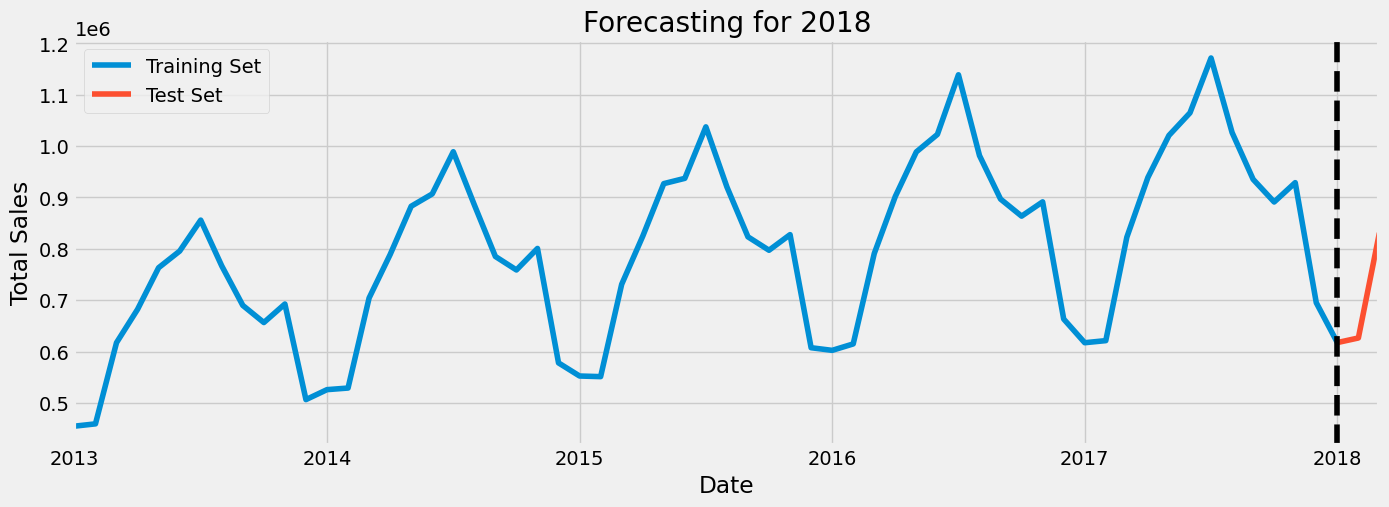

In [116]:
fig, ax = plt.subplots(figsize=(15,5))
total_sales_df[("sales","sum")].plot(ax= ax,
                    label= "Training Set",
                    title= "Forecasting for 2018", 
                    color= color_pal[0],)
pred_total_sales_df[("sales","sum")].plot(ax= ax,
                    label= "Test Set",
                    color= color_pal[1])
ax.axvline(pred_total_sales_df.index.min(), color= "black", ls= "--")
ax.set(xlabel='Date', ylabel='Total Sales')
ax.legend(["Training Set","Test Set",])
plt.show()

# Predicted 2018 Daily Sales

In [117]:
daily_df = future_df.groupby(["date"]).agg({"pred": ["count","sum", "mean", "median", "std", "min", "max"]})
print(daily_df.shape)
daily_df.head()

(90, 7)


pred                                                             
           count           sum       mean     median        std        min   
date                                                                         
2018-01-01   500  16238.465820  32.476933  30.705837  15.133447   8.951296  \
2018-01-02   500  18257.224609  36.514450  33.599754  17.095819   7.742888   
2018-01-03   500  18941.158203  37.882317  35.569042  17.630050   9.398436   
2018-01-04   500  19883.146484  39.766293  37.569298  18.648975  10.183661   
2018-01-05   500  21236.392578  42.472786  40.732986  19.494226  10.430348   

                       
                  max  
date                   
2018-01-01  70.402596  
2018-01-02  80.229858  
2018-01-03  91.800674  
2018-01-04  94.109833  
2018-01-05  95.649078

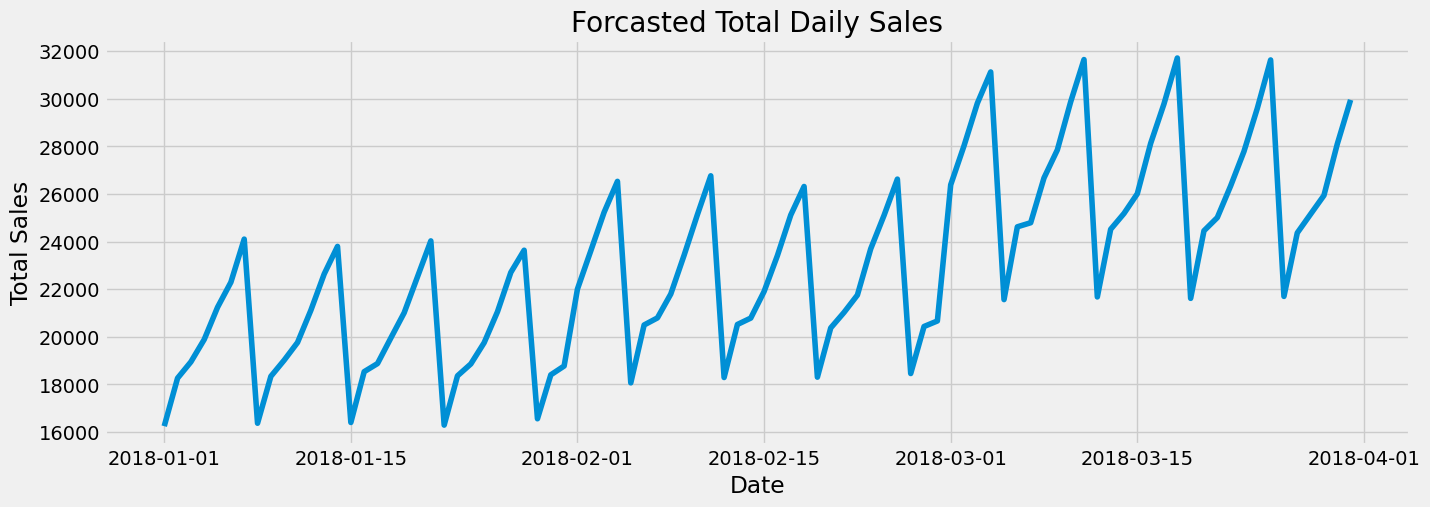

In [118]:
# Daily sales in 2018 for all stores
plt.figure(figsize=(15,5))

ax = sns.lineplot(data= daily_df,x='date',y=('pred','sum'),color= color_pal[0])
ax.set(xlabel='Date', ylabel='Total Sales', title='Forcasted Total Daily Sales')
plt.show()

## Output to CSV

In [119]:
output_df = pd.DataFrame(future_df["pred"]).rename(columns={"pred":"sales"}).reset_index(drop=True).rename_axis('id', axis=1)
print(output_df.shape)
output_df.head()

(45000, 1)


id,sales
0,13.206521
1,13.351491
2,15.880483
3,16.709322
4,17.440975


In [120]:
output_df.to_csv("../results/submission.csv", index=True, index_label= "id")